In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [3]:
# What kind of data/files we have there?
import os
for dirname, _, filenames in os.walk('/kaggle/input/denoising-dirty-documents'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


In [16]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'

# unzip files first to working directory
# We could use also unzipped data source, but why not to learn something new?
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall()  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall()  
      

In [5]:
# store image names in list for later use
def images_name(file_dir):
    import os
    lst = []
    for dirname, _, filenames in os.walk(file_dir):
        for filename in filenames:
            lst.append(os.path.join(dirname, filename).split("/")[-1])
    return sorted(lst)

train_names = images_name("/kaggle/working/train")
train_cleaned_names = images_name("/kaggle/working/train_cleaned")
test_dir = ("/kaggle/working/test")


In [6]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [7]:
# Reshape images and put them into list.
def images_paths(file_dir):
    import os
    lst = []
    for dirname, _, filenames in os.walk(file_dir):
        for filename in filenames:
            lst.append(os.path.join(dirname, filename))
    return sorted(lst)

train = [process_image(p) for p in images_paths("/kaggle/working/train")]
train_cleaned = [process_image(p) for p in images_paths("/kaggle/working/train_cleaned")]
test = [process_image(p) for p in images_paths("/kaggle/working/test")]


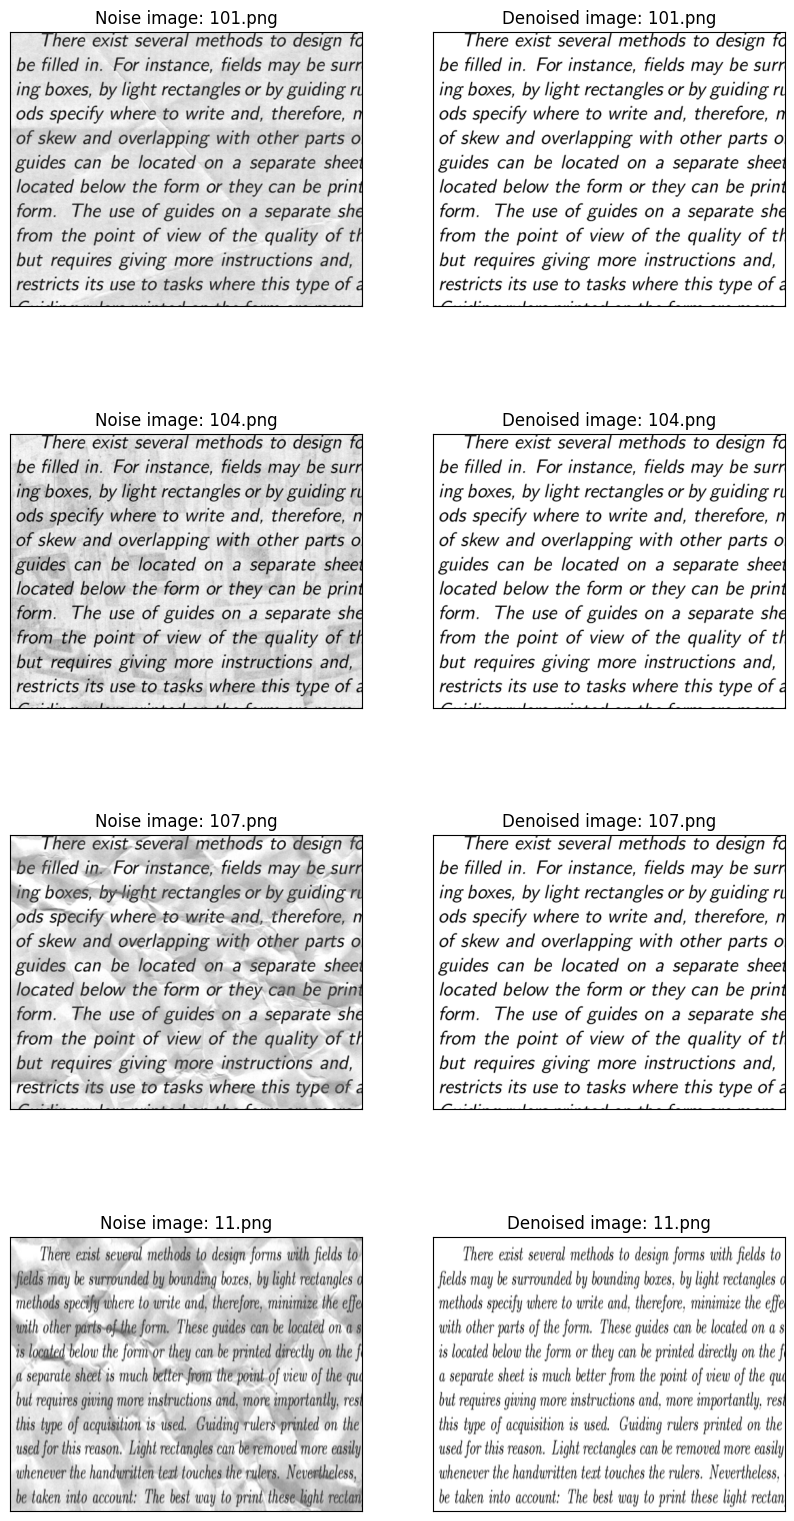

In [8]:
# Not too much to look there, but just quickly look on train images and their cleaned version. 
# This is what we put into model to learn how to clean noise from background.
plt.figure(figsize=(10,20))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_names[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_names[i]))

plt.show()

In [ ]:
# Split data:
# In this step we convert lists to numpy arrays and split dataset 
# into train and validation in ratio 85% train, 15% test.

# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [ ]:
# create model 
def model():
    input_layer = Input(shape=(420, 540, 1))  
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['accuracy'])

    return model


model = model()
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 420, 540, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 420, 540, 64)      640       
                                                                 
 conv2d_6 (Conv2D)           (None, 420, 540, 128)     73856     
                                                                 
 batch_normalization_2 (Batc  (None, 420, 540, 128)    512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 210, 270, 128)    0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 210, 270, 128)     0   

In [ ]:
#Train model

# Verbose is going to be set to 0 to avoid filling output with hundreds of lines from training. 
# We will run 300 epochs having early stopping set to 20 (if val loss does not drop in 20 epochs, it will stop).
# Let's store history of model as well, so i can plot loss (rmse) and accuracy.

callback = EarlyStopping(monitor='loss', patience=5)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), 
                    epochs=30, batch_size=8, callbacks=[callback])

Epoch 1/30


2023-12-29 08:18:19.405998: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 13s 706ms/step - loss: 0.1099 - accuracy: 0.6037 - val_loss: 0.1553 - val_accuracy: 0.6634
Epoch 2/30
16/16 [==============================] - 11s 700ms/step - loss: 0.0417 - accuracy: 0.6614 - val_loss: 0.0888 - val_accuracy: 0.6634
Epoch 3/30
16/16 [==============================] - 11s 710ms/step - loss: 0.0287 - accuracy: 0.6646 - val_loss: 0.0713 - val_accuracy: 0.6634
Epoch 4/30
16/16 [==============================] - 11s 710ms/step - loss: 0.0219 - accuracy: 0.6654 - val_loss: 0.0677 - val_accuracy: 0.6634
Epoch 5/30
16/16 [==============================] - 11s 700ms/step - loss: 0.0179 - accuracy: 0.6658 - val_loss: 0.0686 - val_accuracy: 0.6634
Epoch 6/30
16/16 [==============================] - 11s 697ms/step - loss: 0.0132 - accuracy: 0.6661 - val_loss: 0.0692 - val_accuracy: 0.6634
Epoch 7/30
16/16 [==============================] - 11s 699ms/step - loss: 0.0110 - accuracy: 0.6661 - val_loss: 0.0713 - val_accuracy: 0.6634
Epoch 8/30

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
# Save the trained autoencoder model
model.save("/kaggle/working/autoencoder_model.h5")

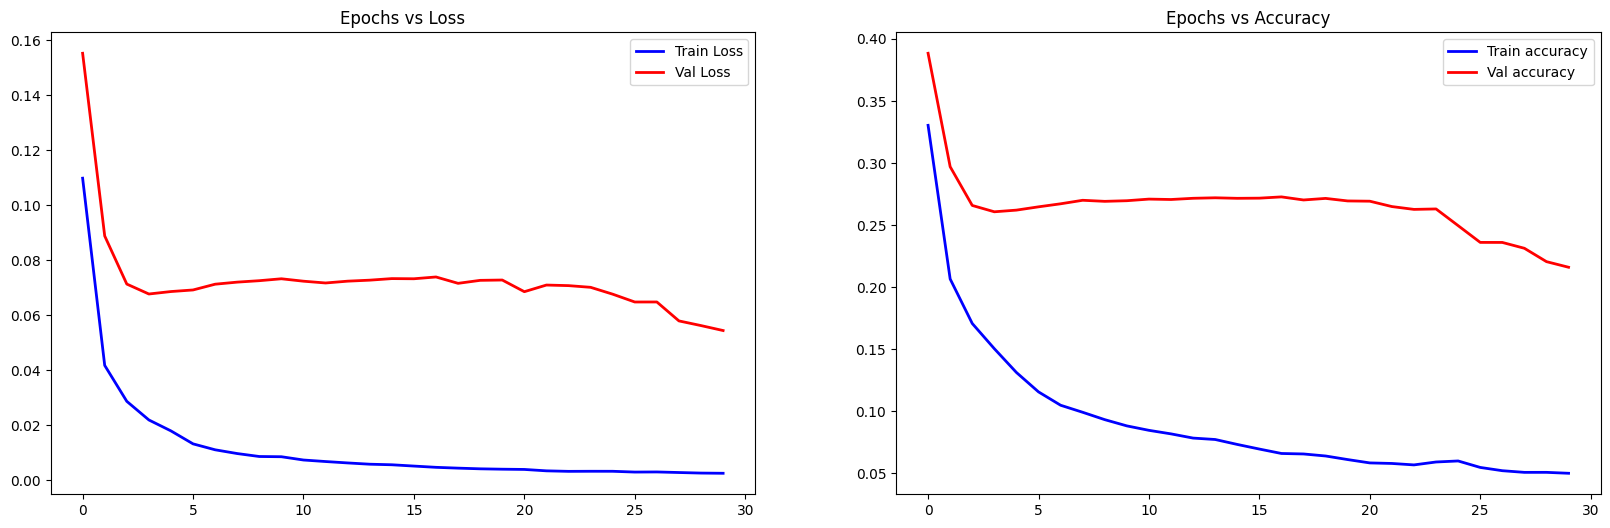

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']


plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Epochs vs Loss')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train accuracy')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val accuracy ')
plt.title('Epochs vs Accuracy')
plt.legend(loc='best')

plt.show()

In [28]:
# predict/clean test images
Y_test = model.predict(X_test)



3/3 [==============================] - 1s 460ms/step


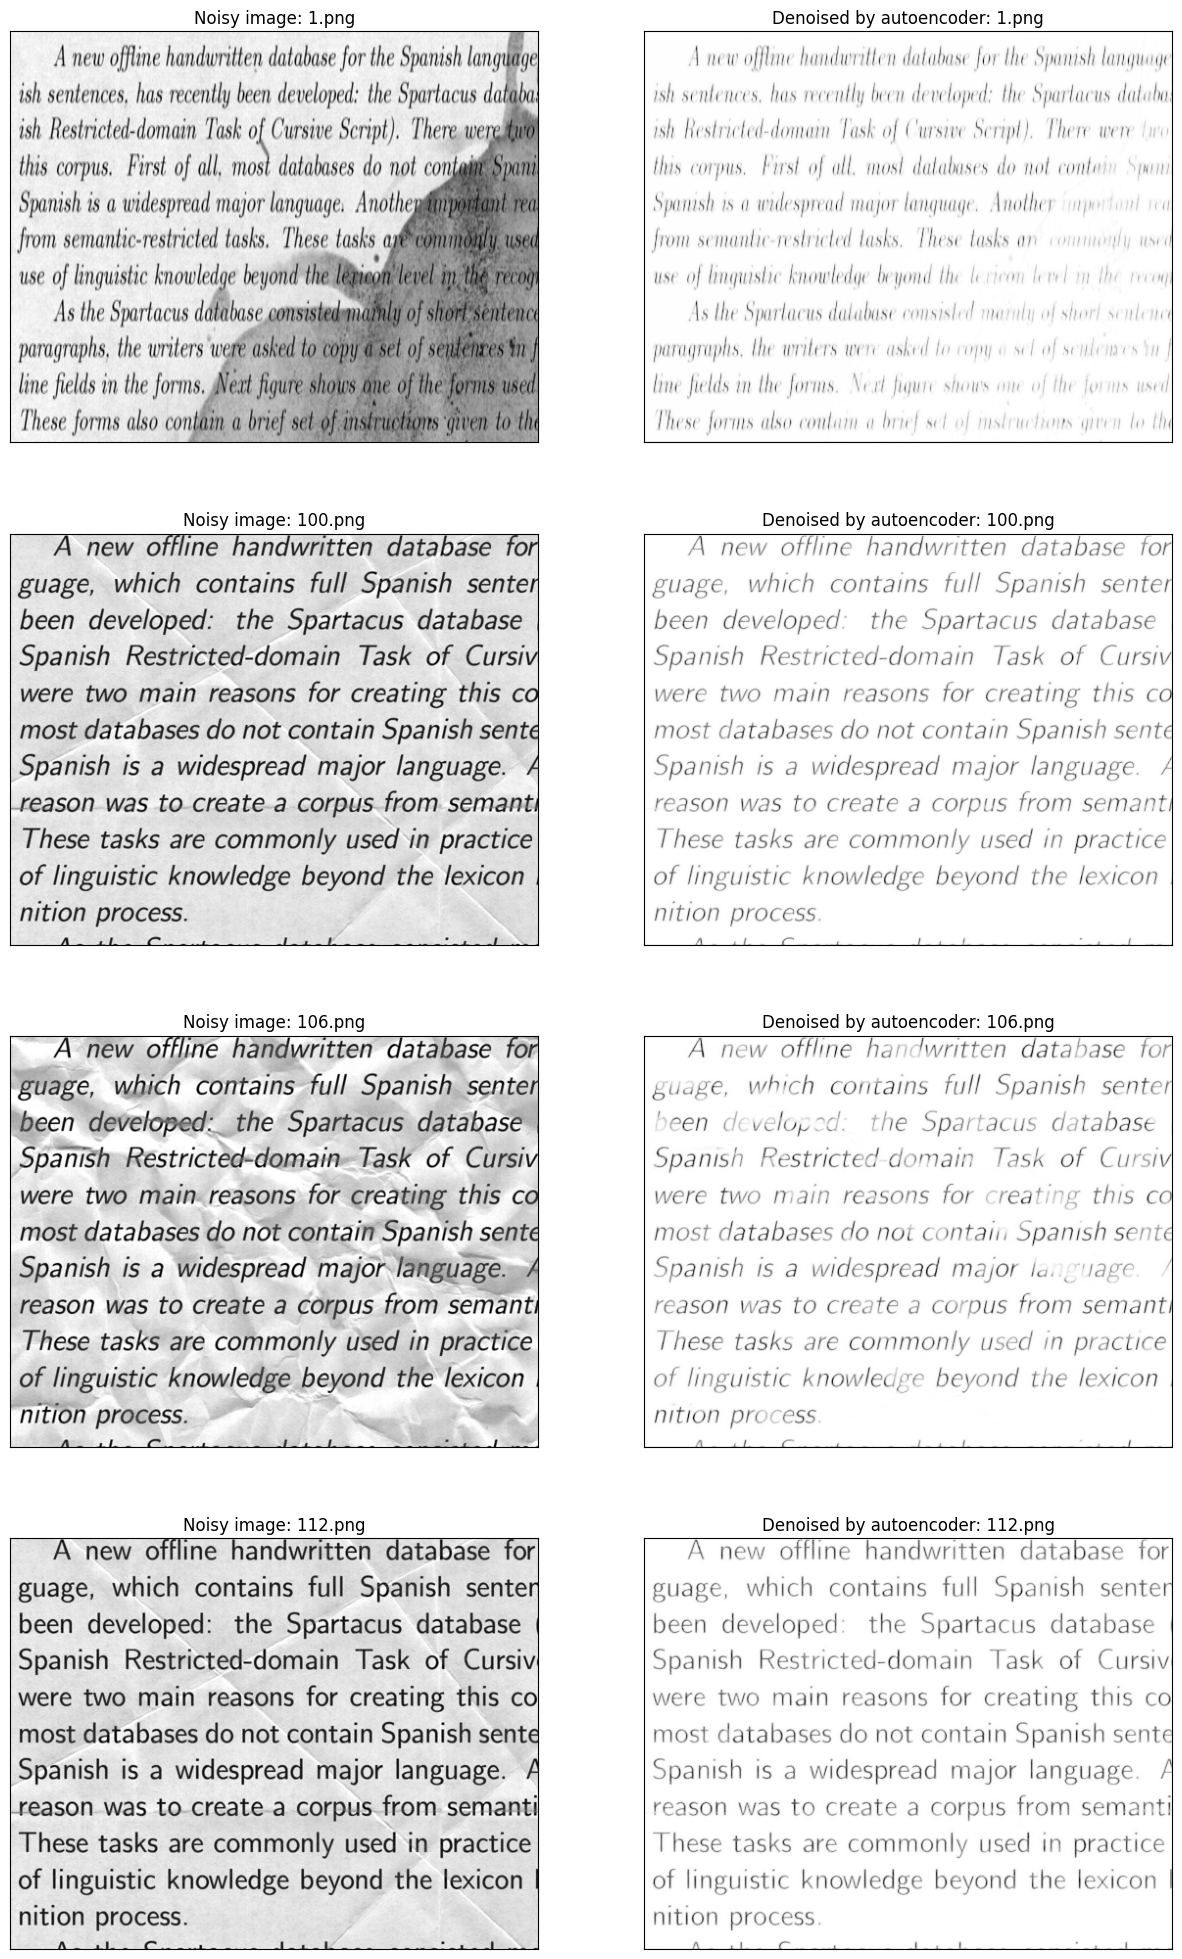

In [29]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_names[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_names[i]))

plt.show()

In [31]:
from PIL import Image
import os
import numpy as np

def load_and_preprocess_test_images(test_dir, target_size=(420, 540)):
    test_images = []

    for file in os.listdir(test_dir):
        test_path = os.path.join(test_dir, file)

        # Load and resize test images
        test_img = Image.open(test_path).resize(target_size)

        # Convert to a numpy array
        test_img_array = np.array(test_img) / 255.0

        test_images.append(test_img_array)

    # Convert the list to a numpy array
    x_test = np.array(test_images)

    # Add an extra dimension to the test images
    x_test = x_test[..., np.newaxis]

    return x_test


In [39]:
test_dir = ("/kaggle/working/test")
x_test = load_and_preprocess_test_images(test_dir)

In [44]:
# Now you can use x_test for predictions using your trained model
decoded_test_images =model.predict(x_test)

3/3 [==============================] - 1s 465ms/step


In [ ]:
# Access the original test images from the generator
original_test_images = test_generator.next()
num_samples = 5
# Display original and decoded images for comparison
for i in range((num_samples)):
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_test_images[i, :, :, 0], cmap='gray')
    plt.title('Original Image')

    # Decoded Image
    plt.subplot(1, 2, 2)
    plt.imshow(decoded_test_images[i, :, :, 0], cmap='gray')
    plt.title('Decoded Image')

    plt.show()


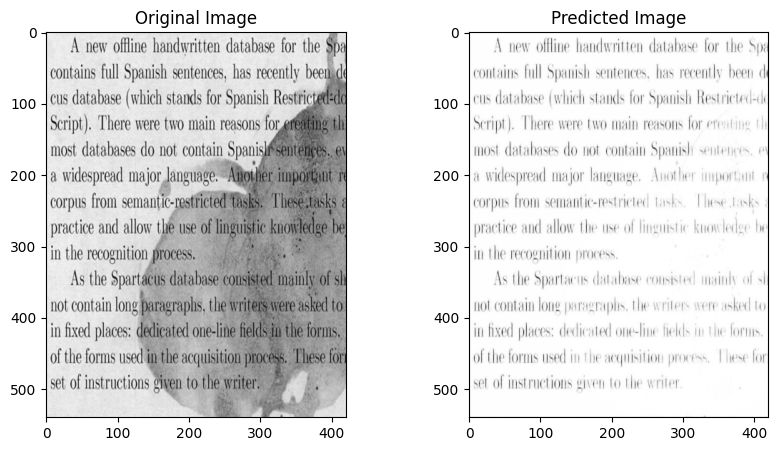

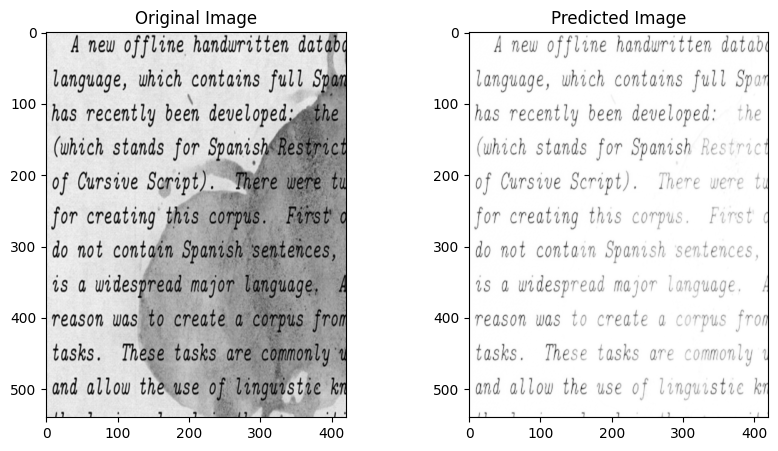

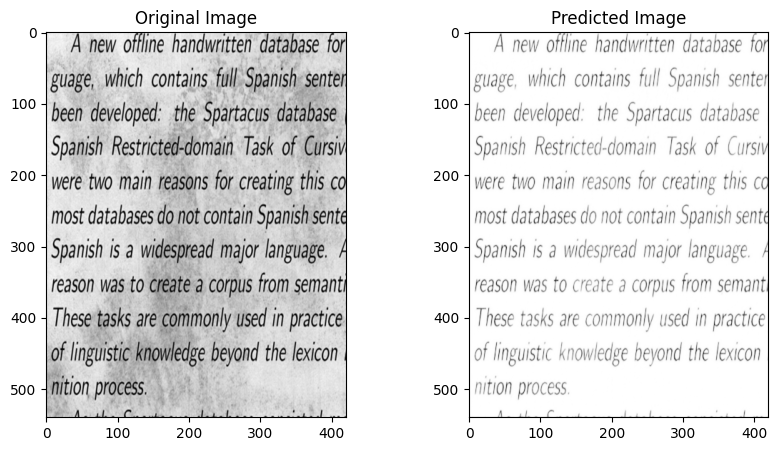

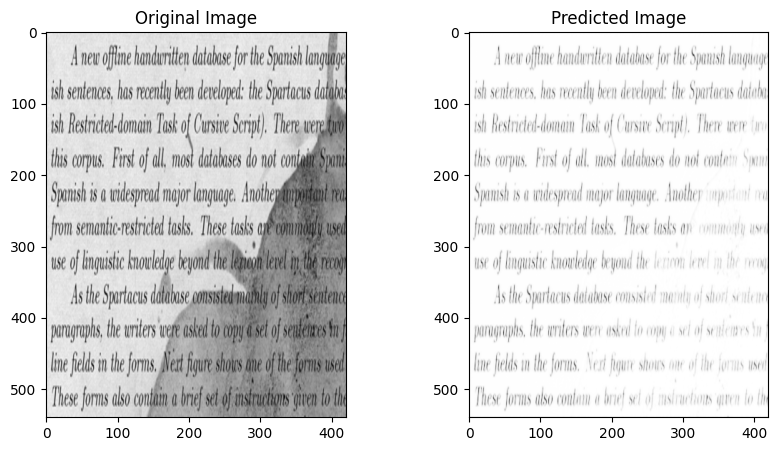

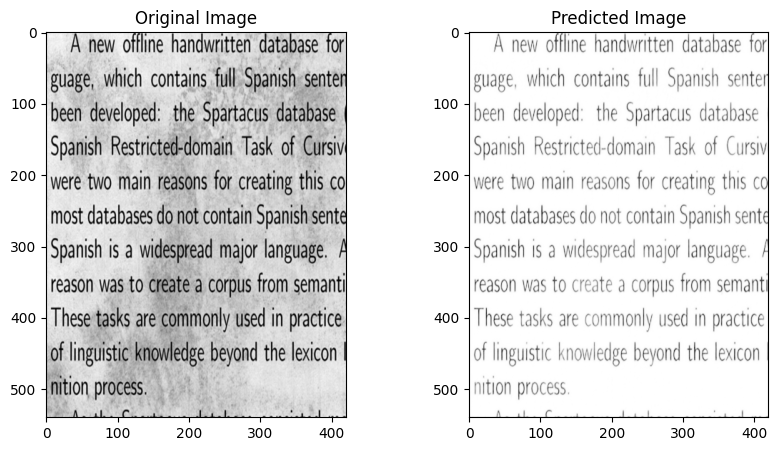

In [45]:
# Plot original and predicted images for visual comparison
num_samples = min(5, len(x_test))  # Choose the number of samples to visualize

for i in range(num_samples):
    original_img = x_test[i, ..., 0]  # Assuming single-channel images
    predicted_img = decoded_test_images[i, ..., 0]

    # Plot original image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    # Plot predicted image
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_img, cmap='gray')
    plt.title('Predicted Image')

    plt.show()

In [46]:
# Print the shape of the decoded images
print("Shape of Decoded Test Images:", decoded_test_images.shape)


Shape of Decoded Test Images: (72, 540, 420, 1)


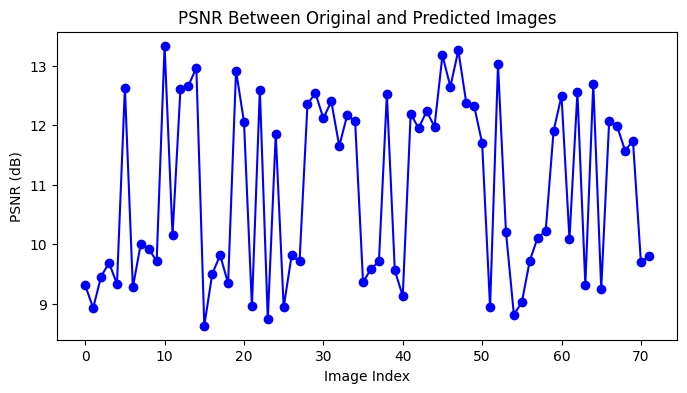

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Define the calculate_psnr function
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = 1.0  # Assuming pixel values are normalized between 0 and 1
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Assuming 'x_test' is the original and 'decoded_test_images' is the predicted
num_samples = len(x_test)
psnr_values = []

for i in range(num_samples):
    psnr_value = calculate_psnr(x_test[i, ..., 0], decoded_test_images[i, ..., 0])
    psnr_values.append(psnr_value)

# Plot PSNR values
plt.figure(figsize=(8, 4))
plt.plot(psnr_values, marker='o', linestyle='-', color='b')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')
plt.title('PSNR Between Original and Predicted Images')
plt.show()



In [50]:
from PIL import Image
import pytesseract

# Assuming 'predicted_images' is the array of predicted images
for i in range(len(decoded_test_images)):
    # Convert the predicted image from NumPy array to PIL Image
    predicted_img_pil = Image.fromarray((decoded_test_images[i, ..., 0] * 255).astype(np.uint8))

    # Use pytesseract to perform OCR on the predicted image
    predicted_text = pytesseract.image_to_string(predicted_img_pil)

    # Print or use the extracted text
    print(f"Predicted Text for Image {i + 1}:\n{predicted_text}")


Predicted Text for Image 1:
A new offline handwritten database for the Spa
contains full Spanish sentences, has recently beew d
cus database (which stands for Spanish Restriete-d¢
Script). There were two iain reasons for eresting 1h
most databases do not contain Spanish sentences. e
a widespread major language. Another iaportant
corpus from semantic-restrieted tasks. Phese tasks 4
practice and allow the use of linguistic knowledge be
in the recognition process

As the Spartacus database consisted snail, of sh
not contain long paragraplis. the writers were asked to
in fixed places: dedicated one-line fields in the forms
of the formis used 1 !he acquisition process. [hese for

set of instructions given to the writer

Predicted Text for Image 2:
A new offline handwritten datab
language, which contains full Span
has recently been developed: the
(which stands for Spanish Restrict
of Cursive Script). There were tu
for creating this corpus. Furst’ ¢
do not contain Spanish sentences,
48 a wid